# Create Benchmark Models:

> 

In [ ]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [ ]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [ ]:
df

,cont_africa,rugged,rgdppc_2000
2,1,0.858,7.492609
4,0,3.427,8.216929
7,0,0.769,9.933263
8,0,0.775,9.407032
9,0,2.688,7.792343
...,...,...,...
229,0,1.677,8.488849
230,0,2.323,6.669180
231,1,1.761,9.150497
232,1,0.533,6.651585


In [ ]:
import plotly.express as px
df['cont_africa_str'] = df['cont_africa'].astype(str)
fig = px.scatter(df, x = 'rugged', y = 'rgdppc_2000', color = 'cont_africa_str', trendline='ols')
fig.show()

In [ ]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [ ]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 3179.7849
[iteration 0100] loss: 1616.1371
[iteration 0150] loss: 1109.4115
[iteration 0200] loss: 833.7544
[iteration 0250] loss: 637.5822
[iteration 0300] loss: 488.2652
[iteration 0350] loss: 376.4650
[iteration 0400] loss: 296.0483
[iteration 0450] loss: 240.6140
[iteration 0500] loss: 203.9386
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3494
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8847
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

In [ ]:
from plotly import graph_objects as go

In [ ]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

In [ ]:
fit

,cont_africa,rugged,rgdppc_2000,cont_africa_str,cont_africa_x_rugged,mean
2,1,0.858,7.492609,1,0.858,7.438684
4,0,3.427,8.216929,0,0.000,8.528131
7,0,0.769,9.933263,0,0.000,9.067137
8,0,0.775,9.407032,0,0.000,9.065921
9,0,2.688,7.792343,0,0.000,8.677990
...,...,...,...,...,...,...
229,0,1.677,8.488849,0,0.000,8.883007
230,0,2.323,6.669180,0,0.000,8.752007
231,1,1.761,9.150497,1,1.761,7.610720
232,1,0.533,6.651585,1,0.533,7.376766


In [ ]:
fig = px.scatter(df, x = 'rugged', y = 'rgdppc_2000', color = 'cont_africa_str')

for e in ['0', '1']:
    dat = fit.loc[fit.cont_africa_str == e,]
    fig.add_trace(go.Scatter(x = dat['rugged'], y = dat['mean'], 
                             marker_color= {'0':'red', '1':'blue'}[e], text= e))
    
fig.show()

In [ ]:
# from frequentist to bayesian: use Stochastic Variational Inference (SVI) to learn posterior dists.
# SVI aims to minimize KL divergence between a given family of distributions and and the posterior
"""
BayesianRegression uses PyroModule[nn.Linear] _but_ to add priors for w, b they become PyroSample statements

"""

'\nBayesianRegression uses PyroModule[nn.Linear] _but_ to add priors for w, b they become PyroSample statements\n\n'

In [ ]:
from pyro.nn import PyroSample # needed to make weight and bias priors

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        # this is set as a wide prior to get a value well above 0 (Probably not cauchy for simplicity in teaching)
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None): # The generative process
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.)) # learnable noise of observation
        mean = self.linear(x).squeeze(-1) # Samples weight and bias parameters above
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y) # obs conditions on y
        return mean



In [ ]:
from pyro.infer.autoguide import AutoDiagonalNormal #gaussian with diagonal covariance

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [ ]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03}) # for fixed effect freq. above thiss was with torch.optim
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [ ]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data) # <---------- here's where the data is input
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5269
[iteration 0201] loss: 3.2377
[iteration 0301] loss: 3.0867
[iteration 0401] loss: 2.6374
[iteration 0501] loss: 2.0617
[iteration 0601] loss: 1.4856
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4939
[iteration 1101] loss: 1.4989
[iteration 1201] loss: 1.4937
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


In [ ]:
# Look at estimates in param store
guide.requires_grad_(False)

# There are (5,) values here which are 3 coeffients, 1 intercept, 1 sigma
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3790,  9.1824])
AutoDiagonalNormal.scale tensor([0.0552, 0.1143, 0.0387, 0.0769, 0.0700])


In [ ]:
guide.quantiles([0.25, 0.5, 0.75]) 
#         sigma prior: N(0, 10)
# linear.weight prior: N(0,  1)
#   linear.bias prior: N(0, 10)

{'sigma': tensor([0.9327, 0.9647, 0.9976]),
 'linear.weight': tensor([[[-1.8868, -0.1952,  0.3272]],
 
         [[-1.8097, -0.1691,  0.3790]],
 
         [[-1.7325, -0.1430,  0.4309]]]),
 'linear.bias': tensor([[9.1351],
         [9.1824],
         [9.2296]])}

In [ ]:
# Model evaluation

from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, 
                        guide=guide,
                        num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [ ]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

In [ ]:
# 90% CI mean

fig = go.Figure()
for e in ['0', '1']:
    dat = predictions.loc[(predictions.cont_africa == float(e))]
    dat = dat.sort_values('rugged')
    current_color = {'0':'red', '1':'blue'}[e]

    fig.add_traces([
        go.Scatter(
            name=e,
            x=dat['rugged'],
            y=dat['true_gdp'],
            mode='markers',
            line=dict(color= current_color),
        ),
        go.Scatter(
            name='',
            x=dat['rugged'],
            y=dat['mu_mean'],
            mode='lines',
            line=dict(color= current_color),
        ),
        go.Scatter(
            name='Upper Bound',
            x=dat['rugged'],
            y=dat['mu_perc_95'],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=dat['rugged'],
            y=dat['mu_perc_5'],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])

fig.show()

In [ ]:
# 90% posterior predictive

fig = go.Figure()
for e in ['0', '1']:
    dat = predictions.loc[(predictions.cont_africa == float(e))]
    dat = dat.sort_values('rugged')
    current_color = {'0':'red', '1':'blue'}[e]

    fig.add_traces([
        go.Scatter(
            name=e,
            x=dat['rugged'],
            y=dat['true_gdp'],
            mode='markers',
            line=dict(color= current_color),
        ),
        go.Scatter(
            name='',
            x=dat['rugged'],
            y=dat['y_mean'],
            mode='lines',
            line=dict(color= current_color),
        ),
        go.Scatter(
            name='Upper Bound',
            x=dat['rugged'],
            y=dat['y_perc_95'],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=dat['rugged'],
            y=dat['y_perc_5'],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])

fig.show()

In [ ]:
# How robust are estimates?

weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]

In [ ]:
import plotly.figure_factory as ff

# Group data together
hist_data = [list(gamma_outside_africa), list(gamma_within_africa)]

group_labels = ['0', '1']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.02)
fig.show()

## Part 2 Inference

In [ ]:
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.8.6')



In [ ]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [ ]:
## Rewrite model without using PyroModule (previously guide was AutoDiagonalNormal)

def model(is_cont_africa, ruggedness, log_gdp):
    a     = pyro.sample("a",     dist.Normal(0., 10.))
    b_a   = pyro.sample("bA",    dist.Normal(0., 1.))
    b_r   = pyro.sample("bR",    dist.Normal(0., 1.))
    b_ar  = pyro.sample("bAR",   dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean  = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc =         pyro.param('a_loc', torch.tensor(0.))
    a_scale =       pyro.param('a_scale', torch.tensor(1.),
                               constraint=constraints.positive) # Constrained to be positive
    sigma_loc =     pyro.param('sigma_loc', torch.tensor(1.),
                               constraint=constraints.positive) # Constrained to be positive
    weights_loc =   pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive) # Constrained to be positive
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [ ]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [ ]:
# Prepare training data
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)] # Ensure is not inf or nan
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

In [ ]:
# SVI
from pyro.infer import SVI, Trace_ELBO

svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 5795.468078792095
Elbo loss: 415.8169758915901
Elbo loss: 250.71916282176971
Elbo loss: 247.1945583820343
Elbo loss: 249.20037305355072
Elbo loss: 250.96484452486038
Elbo loss: 249.35092639923096
Elbo loss: 248.78312534093857
Elbo loss: 248.6214361190796
Elbo loss: 250.42744344472885


In [ ]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

# Distribution of latent variables
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%      50%       75%       95%
0  9.177024  0.059607  9.078109  9.140462  9.17821  9.217097  9.271518 

Site: bA
       mean       std       5%       25%       50%       75%       95%
0 -1.890622  0.122805 -2.08849 -1.979106 -1.887476 -1.803683 -1.700853 

Site: bR
       mean       std       5%       25%       50%       75%       95%
0 -0.157847  0.039538 -0.22324 -0.183672 -0.157872 -0.133102 -0.091713 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.304515  0.067683  0.194583  0.259464  0.304908  0.348932  0.415128 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.902898  0.047971  0.824166  0.870317  0.901981  0.935171  0.981577 



In [ ]:
# Use MCMC to get exact inference. Using No-U Turn Sampler for HMC
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|████████████████████████████████████████| 1200/1200 [00:17, 70.47it/s, step size=3.56e-01, acc. prob=0.938]


In [ ]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%     75%      95%
0  9.168174  0.137013  8.949278  9.076773  9.167389  9.2632  9.38696 

Site: bA
       mean       std       5%       25%       50%      75%       95%
0 -1.832517  0.219724 -2.19043 -1.983763 -1.833418 -1.68951 -1.482666 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.344184  0.130398  0.121738  0.260859  0.346588  0.429631  0.553871 

Site: bR
       mean       std        5%       25%       50%       75%      95%
0 -0.178366  0.076801 -0.298245 -0.230331 -0.180456 -0.132061 -0.04866 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.953294  0.053144  0.873509  0.913733  0.948976  0.989688  1.045702 



In [ ]:
# compare Posterior Distributions
# sites = ["a", "bA", "bR", "bAR", "sigma"]
# i = 0
# site = sites[i]
site = 'a'

hist_data = [list(svi_samples[site]), list(hmc_samples[site])]
group_labels = ['SVI', 'HMC']
fig = ff.create_distplot(hist_data, group_labels, bin_size=.02)
fig.show()

In [ ]:
px.density_contour(pd.merge(pd.DataFrame(svi_samples).assign(label = 'SVI'),
                            pd.DataFrame(hmc_samples).assign(label = 'HMC'), 
                            how = 'outer'), x = 'bA', y = 'bR', color = 'label')


## SARS-CoV-2 Demo

In [ ]:
# for data that doesn't fit in memory consider  amortized variational inference http://pyro.ai/examples/svi_part_ii.html

In [ ]:
from collections import defaultdict
from pprint import pprint
import functools
import math
import os
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import (
    AutoDelta,
    AutoNormal,
    AutoMultivariateNormal,
    AutoLowRankMultivariateNormal,
    AutoGuideList,
    init_to_feasible,
)
from pyro.infer.reparam import AutoReparam, LocScaleReparam
from pyro.nn.module import PyroParam
from pyro.optim import ClippedAdam
from pyro.ops.special import sparse_multinomial_likelihood
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("Using GPU")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    print("Using CPU")
smoke_test = ('CI' in os.environ)



Using GPU


In [ ]:
from pyro.contrib.examples.nextstrain import load_nextstrain_counts
dataset = load_nextstrain_counts()

def summarize(x, name=""):
    if isinstance(x, dict):
        for k, v in sorted(x.items()):
            summarize(v, name + "." + k if name else k)
    elif isinstance(x, torch.Tensor):
        print(f"{name}: {type(x).__name__} of shape {tuple(x.shape)} on {x.device}")
    elif isinstance(x, list):
        print(f"{name}: {type(x).__name__} of length {len(x)}")
    else:
        print(f"{name}: {type(x).__name__}")
summarize(dataset)

counts: Tensor of shape (27, 202, 1316) on cuda:0
features: Tensor of shape (1316, 2634) on cuda:0
lineages: list of length 1316
locations: list of length 202
mutations: list of length 2634
sparse_counts.index: Tensor of shape (3, 57129) on cuda:0
sparse_counts.total: Tensor of shape (27, 202) on cuda:0
sparse_counts.value: Tensor of shape (57129,) on cuda:0
start_date: datetime
time_step_days: int


In [ ]:
def model(dataset):
    features = dataset["features"]
    counts = dataset["counts"]
    assert features.shape[0] == counts.shape[-1]
    S, M = features.shape
    T, P, S = counts.shape
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5
    time -= time.mean()
    strain_plate = pyro.plate("strain", S, dim=-1)
    place_plate = pyro.plate("place", P, dim=-2)
    time_plate = pyro.plate("time", T, dim=-3)

    # Model each region as multivariate logistic growth.
    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4, 2))
    init_scale = pyro.sample("init_scale", dist.LogNormal(0, 2))
    with pyro.plate("mutation", M, dim=-1):
        coef = pyro.sample("coef", dist.Laplace(0, 0.5))
    with strain_plate:
        rate_loc = pyro.deterministic("rate_loc", 0.01 * coef @ features.T)
    with place_plate, strain_plate:
        rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
        init = pyro.sample("init", dist.Normal(0, init_scale))
    logits = init + rate * time[:, None, None]

    # Observe sequences via a multinomial likelihood.
    with time_plate, place_plate:
        pyro.sample(
            "obs",
            dist.Multinomial(logits=logits.unsqueeze(-2), validate_args=False),
            obs=counts.unsqueeze(-2),
        )



In [ ]:
# matrix is sparse
print("counts has {:d} / {} nonzero elements".format(
    dataset['counts'].count_nonzero(), dataset['counts'].numel()
))

counts has 57129 / 7177464 nonzero elements


In [ ]:
# dataset.keys()
# dataset['features'][0].shape # S M
# dataset['counts'][0].shape # T P S

In [ ]:
def model(dataset, predict=None):
    features = dataset["features"]
    counts = dataset["counts"]
    sparse_counts = dataset["sparse_counts"]
    assert features.shape[0] == counts.shape[-1]
    S, M = features.shape
    T, P, S = counts.shape
    time = torch.arange(float(T)) * dataset["time_step_days"] / 5.5
    time -= time.mean()

    # Model each region as multivariate logistic growth.
    rate_scale = pyro.sample("rate_scale", dist.LogNormal(-4, 2))
    init_scale = pyro.sample("init_scale", dist.LogNormal(0, 2))
    with pyro.plate("mutation", M, dim=-1):
        coef = pyro.sample("coef", dist.Laplace(0, 0.5))
    with pyro.plate("strain", S, dim=-1):
        rate_loc = pyro.deterministic("rate_loc", 0.01 * coef @ features.T)
        with pyro.plate("place", P, dim=-2):
            rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
            init = pyro.sample("init", dist.Normal(0, init_scale))
    if predict is not None:  # Exit early during evaluation.
        probs = (init + rate * time[predict]).softmax(-1)
        return probs
    logits = (init + rate * time[:, None, None]).log_softmax(-1)

    # Observe sequences via a cheap sparse multinomial likelihood.
    t, p, s = sparse_counts["index"]
    pyro.factor( # <------------------ cheaper equivalent to pyro.sample() 
        "obs",
        sparse_multinomial_likelihood(
            sparse_counts["total"], logits[t, p, s], sparse_counts["value"]
        )
    )

In [ ]:
# Sanity check with mean-field/AutoNormal
def fit_svi(model, guide, lr=0.01, num_steps=1001, log_every=100, plot=True):
    pyro.clear_param_store()
    pyro.set_rng_seed(20211205)
    if smoke_test:
        num_steps = 2

    # Measure model and guide complexity.
    num_latents = sum(
        site["value"].numel()
        for name, site in poutine.trace(guide).get_trace(dataset).iter_stochastic_nodes()
        if not site["infer"].get("is_auxiliary")
    )
    num_params = sum(p.unconstrained().numel() for p in pyro.get_param_store().values())
    print(f"Found {num_latents} latent variables and {num_params} learnable parameters")

    # Save gradient norms during inference.
    series = defaultdict(list)
    def hook(g, series):
        series.append(torch.linalg.norm(g.reshape(-1), math.inf).item())
    for name, value in pyro.get_param_store().named_parameters():
        value.register_hook(
            functools.partial(hook, series=series[name + " grad"])
        )

    # Train the guide.
    optim = ClippedAdam({"lr": lr, "lrd": 0.1 ** (1 / num_steps)})
    svi = SVI(model, guide, optim, Trace_ELBO())
    num_obs = int(dataset["counts"].count_nonzero())
    for step in range(num_steps):
        loss = svi.step(dataset) / num_obs
        series["loss"].append(loss)
        median = guide.median()  # cheap for autoguides
        for name, value in median.items():
            if value.numel() == 1:
                series[name + " mean"].append(float(value))
        if step % log_every == 0:
            print(f"step {step: >4d} loss = {loss:0.6g}")

    # Plot series to assess convergence.
    if plot:
        plt.figure(figsize=(6, 6))
        for name, Y in series.items():
            if name == "loss":
                plt.plot(Y, "k--", label=name, zorder=0)
            elif name.endswith(" mean"):
                plt.plot(Y, label=name, zorder=-1)
            else:
                plt.plot(Y, label=name, alpha=0.5, lw=1, zorder=-2)
        plt.xlabel("SVI step")
        plt.title("loss, scalar parameters, and gradient norms")
        plt.yscale("log")
        plt.xscale("symlog")
        plt.xlim(0, None)
        plt.legend(loc="best", fontsize=8)
        plt.tight_layout()

Found 538452 latent variables and 1068600 learnable parameters
step    0 loss = 277.457
step  100 loss = 62.7519
step  200 loss = 44.2572
step  300 loss = 34.7022
step  400 loss = 30.2724
step  500 loss = 27.4396
step  600 loss = 25.3145
step  700 loss = 23.7955
step  800 loss = 22.6584
step  900 loss = 21.8109
step 1000 loss = 21.1855
CPU times: user 13.6 s, sys: 68.2 ms, total: 13.7 s
Wall time: 13.7 s


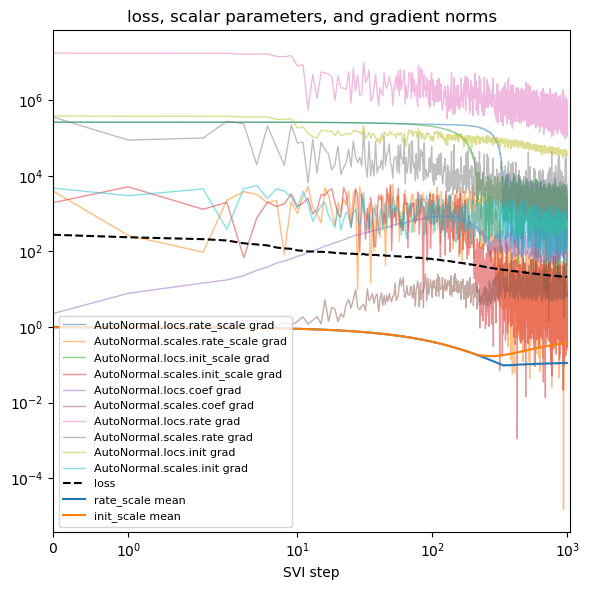

In [ ]:
%%time
guide = AutoNormal(model, init_scale=0.01)
fit_svi(model, guide)

In [ ]:
# validation step
def mae(true_counts, pred_probs):
    """Computes mean average error between counts and predicted probabilities."""
    pred_counts = pred_probs * true_counts.sum(-1, True)
    error = (true_counts - pred_counts).abs().sum(-1)
    total = true_counts.sum(-1).clamp(min=1)
    return (error / total).mean().item()

def evaluate(
    model, guide, num_particles=100, location="USA / Massachusetts", time=-2
):
    if smoke_test:
        num_particles = 4
    """Evaluate posterior predictive accuracy at the last fully observed time step."""
    with torch.no_grad(), poutine.mask(mask=False):  # makes computations cheaper
        with pyro.plate("particle", num_particles, dim=-3):  # vectorizes
            guide_trace = poutine.trace(guide).get_trace(dataset)
            probs = poutine.replay(model, guide_trace)(dataset, predict=time)
        probs = probs.squeeze().mean(0)  # average over Monte Carlo samples
        true_counts = dataset["counts"][time]
        # Compute global and local KL divergence.
        global_mae = mae(true_counts, probs)
        i = dataset["locations"].index(location)
        local_mae = mae(true_counts[i], probs[i])
    return {"MAE (global)": global_mae, f"MAE ({location})": local_mae}

pprint(evaluate(model, guide))

{'MAE (USA / Massachusetts)': 0.23104651272296906,
 'MAE (global)': 0.22675295174121857}


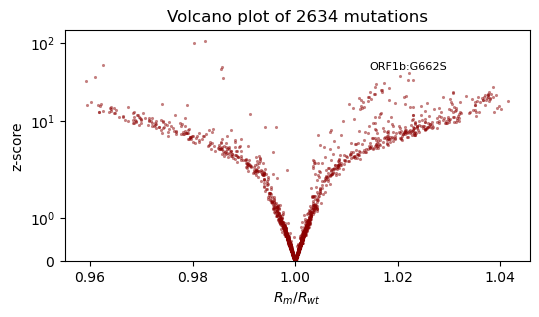

In [ ]:
def plot_volcano(guide, num_particles=100):
    if smoke_test:
        num_particles = 4
    with torch.no_grad(), poutine.mask(mask=False):  # makes computations cheaper
        with pyro.plate("particle", num_particles, dim=-3):  # vectorizes
            trace = poutine.trace(guide).get_trace(dataset)
            trace = poutine.trace(poutine.replay(model, trace)).get_trace(dataset, -1)
            coef = trace.nodes["coef"]["value"].cpu()
    coef = coef.squeeze() * 0.01  # Scale factor as in the model.
    mean = coef.mean(0)
    std = coef.std(0)
    z_score = mean.abs() / std
    effect_size = mean.exp().numpy()
    plt.figure(figsize=(6, 3))
    plt.scatter(effect_size, z_score.numpy(), lw=0, s=5, alpha=0.5, color="darkred")
    plt.yscale("symlog")
    plt.ylim(0, None)
    plt.xlabel("$R_m/R_{wt}$")
    plt.ylabel("z-score")
    i = int((mean / std).max(0).indices)
    plt.text(effect_size[i], z_score[i] * 1.1, dataset["mutations"][i], ha="center", fontsize=8)
    plt.title(f"Volcano plot of {len(mean)} mutations")

plot_volcano(guide)

In [ ]:
# Heuristic for initialization to speed up convergence an prevent NANs
# initialize a point estimate that's around the right order of magnitude for each latent 
# often can use a statistic of the data (e.g., mean, sd)

# def init_loc_fn(site):
#     shape = site["fn"].shape()
#     if site["name"] == "coef":
#         return torch.randn(shape).sub_(0.5).mul(0.01)
#     if site["name"] == "init":
#         # Heuristically initialize based on data.
#         return dataset["counts"].mean(0).add(0.01).log()
#     return init_to_feasible(site)  # fallback

# best practice is to require inits for all latent variables and to remind yourself to update the init_loc_fn when the model changes

def init_loc_fn(site):
    shape = site["fn"].shape()
    if site["name"].endswith("_scale"):
        return torch.ones(shape)
    if site["name"] == "coef":
        return torch.randn(shape).sub_(0.5).mul(0.01)
    if site["name"] == "rate":
        return torch.zeros(shape)
    if site["name"] == "init":
        return dataset["counts"].mean(0).add(0.01).log()
    raise NotImplementedError(f"TODO initialize latent variable {site['name']}")

Found 538452 latent variables and 1068600 learnable parameters
step    0 loss = 125.223
step  100 loss = 45.5515
step  200 loss = 31.3653
step  300 loss = 24.4973
step  400 loss = 20.7008
step  500 loss = 18.3349
step  600 loss = 17.0726
step  700 loss = 16.1049
step  800 loss = 16.0439
step  900 loss = 15.6698
step 1000 loss = 15.2273
{'MAE (USA / Massachusetts)': 0.28059229254722595,
 'MAE (global)': 0.226853147149086}
CPU times: user 14.8 s, sys: 39.8 ms, total: 14.9 s
Wall time: 13.4 s


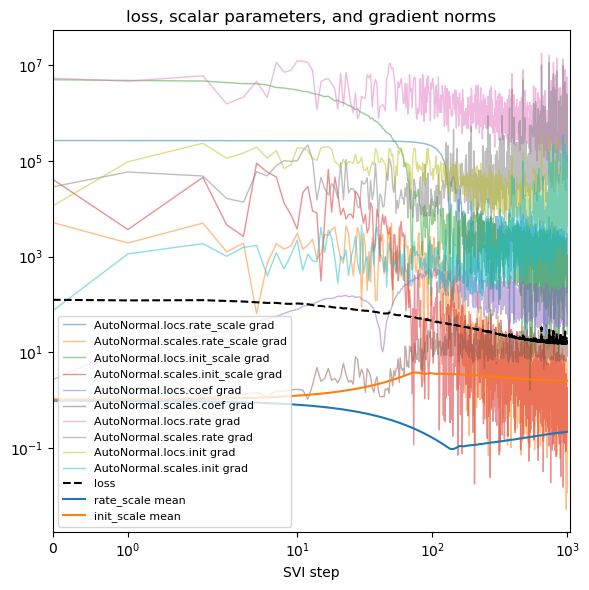

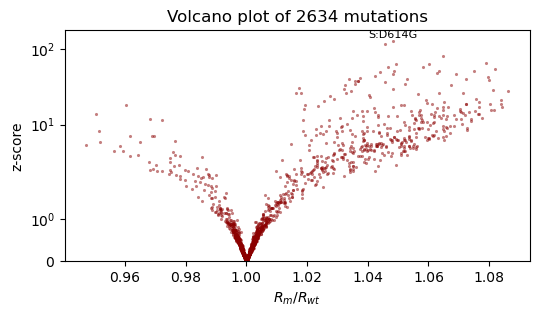

In [ ]:
%%time
guide = AutoNormal(model, init_loc_fn=init_loc_fn, init_scale=0.01)
fit_svi(model, guide, lr=0.02)
pprint(evaluate(model, guide))
plot_volcano(guide)



In [ ]:
# Reparametrizing
# trying to remove correlations and get to a simpler "space". Pyro tries to make this easy by building in reparametrizations.

"""
To make this change
- rate = pyro.sample("rate", dist.Normal(rate_loc, rate_scale))
+ rate = pyro.sample("rate", dist.Normal(0, 1)) * rate_scale + rate_loc
"""

reparam_model = poutine.reparam(model, config={"rate": LocScaleReparam()})
reparam_model = AutoReparam()(model)

Found 538452 latent variables and 1068602 learnable parameters
step    0 loss = 125.487
step  100 loss = 20.0065
step  200 loss = 10.9425
step  300 loss = 9.96108
step  400 loss = 9.4168
step  500 loss = 9.05353
step  600 loss = 10.0793
step  700 loss = 8.88428
step  800 loss = 8.56916
step  900 loss = 9.09832
step 1000 loss = 8.73581
{'MAE (USA / Massachusetts)': 0.11831877380609512,
 'MAE (global)': 0.17374524474143982}
CPU times: user 16.2 s, sys: 23.9 ms, total: 16.2 s
Wall time: 16.1 s


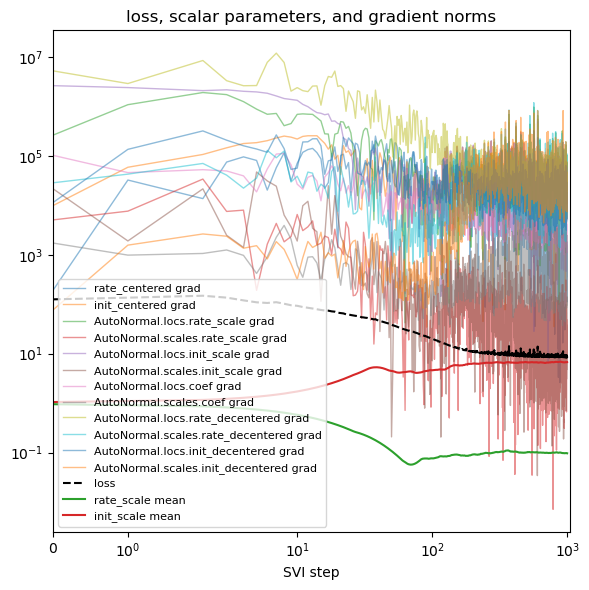

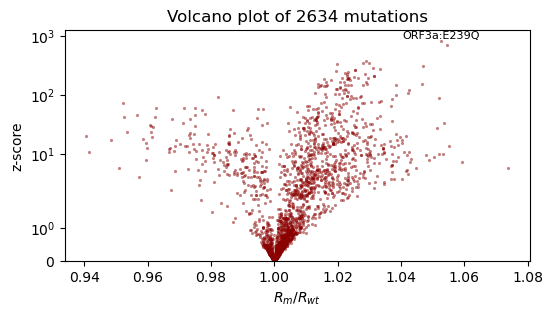

In [ ]:
%%time
reparam_model = poutine.reparam(
    model, {"rate": LocScaleReparam(), "init": LocScaleReparam()}
)
guide = AutoNormal(reparam_model, init_loc_fn=init_loc_fn, init_scale=0.01)
fit_svi(reparam_model, guide, lr=0.05)
pprint(evaluate(reparam_model, guide))
plot_volcano(guide)

## Repeat with my data

In [ ]:
load_from = '../nbs_artifacts/01.03_g2fc_prep_matrices/'
phno_geno = pd.read_csv(load_from+'phno_geno.csv')
phno = phno_geno
obs_geno_lookup = np.load(load_from+'obs_geno_lookup.npy') # Phno_Idx	Geno_Idx	Is_Phno_Idx
YMat = np.load(load_from+'YMat.npy')
ACGT = np.load(load_from+'ACGT.npy')

In [ ]:
ACGT = ACGT[:, :, 0:2]

ACGT = ACGT.reshape((4926, 4*2))
ACGT.shape

(4926, 8)

In [ ]:
# for this small scale test only keep one of each genotype so y and g are 1:1
idxs = list(set(obs_geno_lookup[:, 2]))
idxs.sort()
YMat = YMat[idxs, ]

In [ ]:
device = 'cuda'
x_data = torch.from_numpy(ACGT).type(torch.float).to(device)
y_data = torch.from_numpy(YMat).type(torch.float).to(device)

In [ ]:
[e.shape for e in [x_data, y_data]]

[torch.Size([4926, 8]), torch.Size([4926])]

In [ ]:
# Starting as simple as possible

linear_reg_model = PyroModule[nn.Linear](x_data.shape[1], # I've reshaped to flatten the acgt dim and len dim 
                                         1)


# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.cpu().numpy())


[iteration 0050] loss: 72959.5625
[iteration 0100] loss: 39986.3867
[iteration 0150] loss: 39788.6172
[iteration 0200] loss: 39742.6797
[iteration 0250] loss: 39711.4297
[iteration 0300] loss: 39690.1016
[iteration 0350] loss: 39675.8945
[iteration 0400] loss: 39666.7539
[iteration 0450] loss: 39661.1250
[iteration 0500] loss: 39657.8047
[iteration 0550] loss: 39655.9492
[iteration 0600] loss: 39654.9531
[iteration 0650] loss: 39654.4453
[iteration 0700] loss: 39654.1992
[iteration 0750] loss: 39654.0859
[iteration 0800] loss: 39654.0312
[iteration 0850] loss: 39654.0078
[iteration 0900] loss: 39654.0039
[iteration 0950] loss: 39654.0000
[iteration 1000] loss: 39654.0000
[iteration 1050] loss: 39654.0000
[iteration 1100] loss: 39653.9961
[iteration 1150] loss: 39654.0000
[iteration 1200] loss: 39654.0000
[iteration 1250] loss: 39654.0000
[iteration 1300] loss: 39654.0000
[iteration 1350] loss: 39654.0000
[iteration 1400] loss: 39654.0000
[iteration 1450] loss: 39654.0000
[iteration 150

In [ ]:
linear_reg_model(x_data).detach().cpu().numpy().shape

(4926, 1)

In [ ]:
px.scatter(pd.DataFrame({'y':list(YMat), 
             'yhat':list(linear_reg_model(x_data).detach().cpu().numpy().squeeze(-1))}), 
           x = 'yhat', y = 'y')

In [ ]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [ ]:
model = BayesianRegression(x_data.shape[1], 1)
guide = AutoDiagonalNormal(model)

In [ ]:
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [ ]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 150.8022
[iteration 0101] loss: 87.7857
[iteration 0201] loss: 74.0241
[iteration 0301] loss: 71.6372
[iteration 0401] loss: 71.6669
[iteration 0501] loss: 71.7030
[iteration 0601] loss: 71.6682
[iteration 0701] loss: 71.6169
[iteration 0801] loss: 71.6149
[iteration 0901] loss: 71.6792
[iteration 1001] loss: 71.6529
[iteration 1101] loss: 71.6007
[iteration 1201] loss: 71.6090
[iteration 1301] loss: 71.5883
[iteration 1401] loss: 71.6324


In [ ]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px

import hilbertcurve
from hilbertcurve.hilbertcurve import HilbertCurve

from EnvDL.core import * # includes remove_matching_files
# from EnvDL.dna import *
# from EnvDL.dlfn import *

from tqdm import tqdm

In [ ]:
from sklearn.metrics import mean_squared_error # if squared=False; RMSE
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import optuna

from joblib import Parallel, delayed # Oputna has parallelism built in but for training replicates of the selected model
# I'll run them through Parallel

In [ ]:
cache_path = '../nbs_artifacts/01.81_g2fc_ML_benchmark_pyro_lm/'
ensure_dir_path_exists(dir_path = cache_path)

## Load data

In [ ]:
# load_from = '../nbs_artifacts/01.03_g2fc_prep_matrices/'
# # phno = pd.read_csv(load_from+'phno.csv')
# phno_geno = pd.read_csv(load_from+'phno_geno_filter.csv')
# phno = phno_geno

# obs_geno_lookup = np.load(load_from+'obs_geno_lookup.npy') # Phno_Idx	Geno_Idx	Is_Phno_Idx
# YMat = np.load(load_from+'YMat.npy')
# GMat = np.load(load_from+'GMat.npy')
# # ACGT_OneHot = np.load(load_from+'ACGT_OneHot.npy')
# # ACGT = np.load(load_from+'ACGT.npy')
# # ACGT_hilb = np.load(load_from+'ACGT_hilb.npy')
# SMat = np.load(load_from+'SMat.npy')
# WMat = np.load(load_from+'WMat.npy')
# MMat = np.load(load_from+'MMat.npy')

In [ ]:
# GMatNames = np.load(load_from+'GMatNames.npy')
# SMatNames = np.load(load_from+'SMatNames.npy')
# WMatNames = np.load(load_from+'WMatNames.npy')
# MMatNames = np.load(load_from+'MMatNames.npy')

## SKlearn modeling

In [ ]:
# # transform to panel data
# def wthr_rank_3to2(x_3d):
#     n_obs, n_days, n_metrics = x_3d.shape
#     return(x_3d.reshape(n_obs, (n_days*n_metrics)))

# def wthr_features_rank_2to3(x_3d, feature_import):
#     n_obs, n_days, n_metrics = x_3d.shape
#     return(feature_import.reshape(n_days, n_metrics))

# def y_rank_2to1(y_2d):
#     n_obs = y_2d.shape[0]
#     return(y_2d.reshape(n_obs, ))

In [ ]:
# Placeholder training/testing setup

In [ ]:
# GMat.shape

In [ ]:
# may need to expand matrices for sklearn... 

In [ ]:
# YMat.shape

In [ ]:
# obs_geno_lookup.shape

In [ ]:
# okay_phno_idx = obs_geno_lookup[:, 0]
# np.random.shuffle(okay_phno_idx)
# test_idx  = okay_phno_idx[0:1000]
# train_idx = okay_phno_idx[1000:-1]

In [ ]:
# obs_geno_lookup

In [ ]:
# regr = RandomForestRegressor(max_depth= 16, 
#                              random_state=0,
#                              n_estimators = 20)

#                                  # phno indexes
#                                  # |          geno indexes
# rf = regr.fit(GMat[obs_geno_lookup[train_idx, 1], :], # inflate deduplicated GMat to match what sklearn expects.
#               YMat[train_idx])

In [ ]:
# print([
#         mean_squared_error(YMat[train_idx], rf.predict(GMat[obs_geno_lookup[train_idx, 1], :]), squared=False), 
#         mean_squared_error(YMat[test_idx],  rf.predict(GMat[obs_geno_lookup[test_idx, 1], :]), squared=False)
#     ])

In [ ]:
# yhats = pd.concat([
#     pd.DataFrame(zip(YMat[test_idx],
#                  rf.predict(GMat[obs_geno_lookup[test_idx, 1], :])), 
#                  columns = ['y_true', 'y_pred']).assign(Split = 'Test'),
#     pd.DataFrame(zip(YMat[train_idx],
#                  rf.predict(GMat[obs_geno_lookup[train_idx, 1], :])), 
#                  columns = ['y_true', 'y_pred']).assign(Split = 'Train')
# ])

# # px.scatter(yhats, x = 'y_true', y = 'y_pred', color = 'Split', trendline="ols")

In [ ]:
# px.bar(pd.DataFrame(dict(cols=GMatNames, imp=rf.feature_importances_)), x = 'cols', y = 'imp')

In [ ]:
#  yhats['Error'] = yhats.y_pred - yhats.y_true

# px.histogram(yhats, x = 'Error', color = 'Split',
#              marginal="box", # can be `rug`, `violin`
#              nbins= 50)